# Scenario 1

def SEIRHD_Model(y, t, N, beta, r_I_to_R, r_I_to_H, r_E_to_I, r_H_to_R, r_H_to_D, p_I_to_H, p_I_to_R, p_H_to_D, p_H_to_R):
    S, E, I, R, H, D = y

    dSdt = -beta * I * S / N
    dEdt = beta* I * S / N - r_E_to_I * E
    dIdt = r_E_to_I * E - (r_I_to_H * p_I_to_H) * I - (r_I_to_R * p_I_to_R * I)
    dRdt = (r_I_to_R * p_I_to_R * I) + (r_H_to_R * p_H_to_R * H)
    dHdt = (r_I_to_H * p_I_to_H * I) - (r_H_to_D * p_H_to_D * H)  - (r_H_to_R * p_H_to_R * H)
    dDdt = r_H_to_D * p_H_to_D * H
    return dSdt, dEdt, dIdt, dRdt, dHdt, dDdt

In [1]:
import sympy
from copy import deepcopy as _d
from mira.metamodel import *
from mira.modeling import Model
from mira.modeling.amr.petrinet import template_model_to_petrinet_json_file
from mira.modeling.viz import GraphicalModel

In [2]:
person_units = lambda: Unit(expression=sympy.Symbol('person'))
day_units = lambda: Unit(expression=sympy.Symbol('day'))
per_day_units = lambda: Unit(expression=1/sympy.Symbol('day'))
dimensionless_units = lambda: Unit(expression=sympy.Integer('1'))
per_day_per_person_units = lambda: Unit(expression=1/(sympy.Symbol('day')*sympy.Symbol('person')))

c = {
    'S': Concept(name='S', units=person_units(), identifiers={'ido': '0000514'}),
    'E': Concept(name='E', units=person_units(), identifiers={'apollosv': '0000154'}),
    'I': Concept(name='I', units=person_units(), identifiers={'ido': '0000511'}),
    'R': Concept(name='R', units=person_units(), identifiers={'ido': '0000592'}),
    'H': Concept(name='H', units=person_units(), identifiers={'ido': '0000511'},
                 context={'property': 'ncit:C25179'}),
    'D': Concept(name='D', units=person_units(), identifiers={'ncit': 'C28554'}),
}


N_val = 19_340_000
E_val = 1
I_val = 4

parameters = {
    'beta': Parameter(name='beta', value=0.4, units=per_day_per_person_units()),
    'r_E_to_I': Parameter(name='r_E_to_I', value=0.2, units=per_day_units()),
    'r_I_to_H': Parameter(name='r_I_to_H', value=0.1, units=per_day_units()),
    'p_I_to_H': Parameter(name='p_I_to_H', value=0.2, units=dimensionless_units()),
    'r_I_to_R': Parameter(name='r_I_to_R', value=0.07, units=per_day_units()),
    'p_I_to_R': Parameter(name='p_I_to_R', value=0.8, units=dimensionless_units()),
    'r_H_to_R': Parameter(name='r_H_to_R', value=0.1, units=per_day_units()),
    'p_H_to_R': Parameter(name='p_H_to_R', value=0.88, units=dimensionless_units()),
    'r_H_to_D': Parameter(name='r_H_to_D', value=0.1, units=per_day_units()),
    'p_H_to_D': Parameter(name='p_H_to_D', value=0.12, units=dimensionless_units()),
    'N': Parameter(name='N', value=N_val, units=person_units()),
}


initials = {
    "S": Initial(concept=Concept(name="S"), expression=N_val - (E_val + I_val)),
    "E": Initial(concept=Concept(name="E"), expression=E_val),
    "I": Initial(concept=Concept(name="I"), expression=I_val),
    "R": Initial(concept=Concept(name="R"), expression=0.0),
    "H": Initial(concept=Concept(name="H"), expression=0.0),
    "D": Initial(concept=Concept(name="D"), expression=0.0),
}

observables = {}

In [3]:
S, E, I, R, D, H, N, beta, r_E_to_I, r_E_to_H, r_I_to_H, p_I_to_H, r_I_to_R, p_I_to_R, r_H_to_R, p_H_to_R, r_H_to_D, p_H_to_D = \
    sympy.symbols('S E I R D H N beta r_E_to_I r_E_to_H r_I_to_H p_I_to_H r_I_to_R p_I_to_R r_H_to_R p_H_to_R r_H_to_D p_H_to_D')

In [4]:
t1 = ControlledConversion(subject=c['S'],
                          outcome=c['E'],
                          controller=c['I'],
                          rate_law=S*I*beta / N)
t2 = NaturalConversion(subject=c['E'],
                       outcome=c['I'],
                       rate_law=r_E_to_I*E)
t3 = NaturalConversion(subject=c['I'],
                       outcome=c['R'],
                       rate_law=r_I_to_R*p_I_to_R*I)
t4 = NaturalConversion(subject=c['I'],
                       outcome=c['H'],
                       rate_law=r_I_to_H*p_I_to_H*I)
t5 = NaturalConversion(subject=c['H'],
                       outcome=c['R'],
                       rate_law=r_H_to_R*p_H_to_R*H)
t6 = NaturalConversion(subject=c['H'],
                       outcome=c['D'],
                       rate_law=r_H_to_D*p_H_to_D*H)
templates = [t1, t2, t3, t4, t5, t6]
tm = TemplateModel(
    templates=templates,
    parameters=parameters,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables,
    annotations=Annotations(name='Evaluation Scenario 1 Base model')
)
sanity_check_tm(tm)
template_model_to_petrinet_json_file(tm, 'eval_202307_scenario1_base_petri.json')

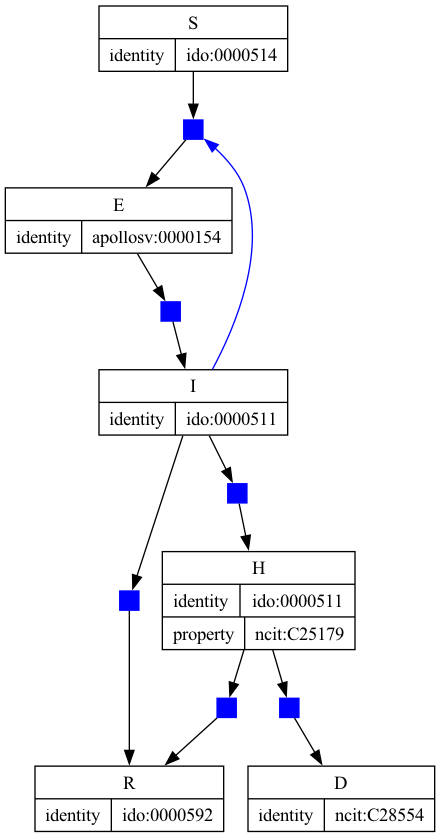

In [5]:
GraphicalModel.for_jupyter(tm)

## Part 1/ii
1) Masking Forecasts: For this question, assume that a masking policy will go into place on April 15th, 2020
a) Starting from April 3rd, 2020, forecast the next four weeks of the pandemic (for cases, hospitalizations, and deaths) assuming the following constant levels of masking compliance: 40%, 60%, and 80%. Assume that any person who complies with the masking policy is wearing a surgical mask. How does compliance affect forecasted cases, hospitalizations, and deaths?

(1) Introduce a modification term to β as described in Srivastav et. al. (DOI: 10.3934/mbe.2021010): (1 − 𝜖𝑚𝑐𝑚), where 𝑐𝑚 is the fraction of the population that wear face masks correctly and consistently (i.e. comply with masking policies), and 𝜖𝑚 is the efficacy of the masks themselves.

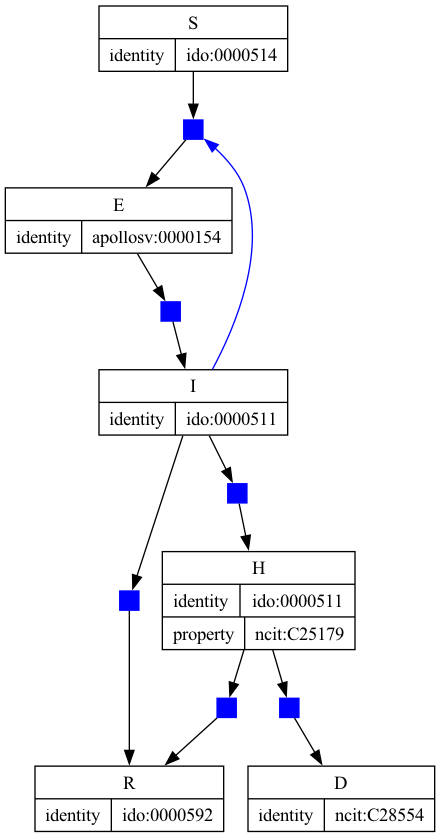

In [6]:
eps_m = sympy.Symbol('eps_m')
c_m = sympy.Symbol('c_m')

t1_alt_1 = ControlledConversion(subject=c['S'],
                          outcome=c['E'],
                          controller=c['I'],
                          rate_law=S*I*beta*(1-eps_m*c_m) / N)

parameters_alt_1 = _d(parameters)
parameters_alt_1['eps_m'] = Parameter(name='eps_m', value=0.5, units=dimensionless_units())
parameters_alt_1['c_m'] = Parameter(name='c_m', value=0.5, units=dimensionless_units())

tm_mask_1 = TemplateModel(
    templates=[t1_alt_1, t2, t3, t4, t5, t6],
    parameters=parameters_alt_1,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables,
    annotations=Annotations(name='Evaluation Scenario 1. Part 1 (ii) Masking type 1')
)

sanity_check_tm(tm_mask_1)
template_model_to_petrinet_json_file(tm_mask_1, 'eval_202307_scenario1_1_ii_1_petri.json')


GraphicalModel.for_jupyter(tm_mask_1)

(2) Adjust the transmission rate following an intervention period and create a time- varying β function, as shown in https://doi.org/10.3390/ijerph18179027

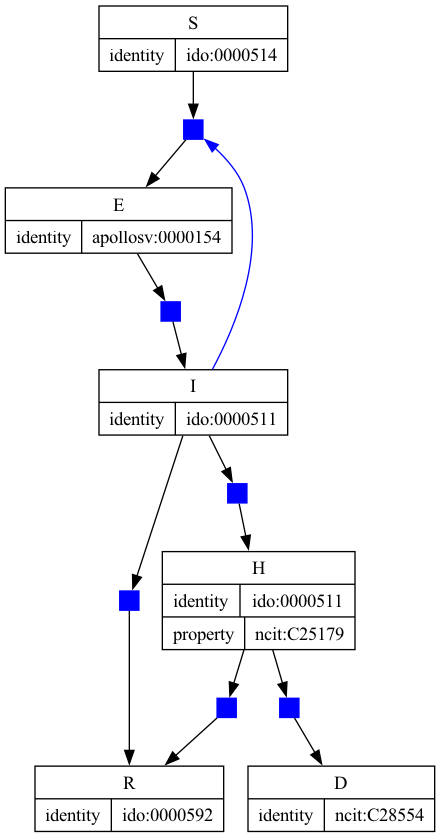

In [7]:
new_params = {
    'beta_s': Parameter(name='beta_s', value=1, units=per_day_units()),
    'beta_c': Parameter(name='beta_c', value=0.4, units=per_day_units()),
    't_0': Parameter(name='t_0', value=89, unts=day_units, units=day_units()),
    'kappa': Parameter(name='kappa', value=5/11, units=per_day_units()),
    'k': Parameter(name='k', value=5.0, units=dimensionless_units()),
}
beta_s, beta_c, t_0, kappa, k, t = sympy.symbols('beta_s beta_c t_0 kappa k t')
m_1 = (beta_s - beta_c) / (1 + sympy.exp(-k*(t_0-t))) + beta_c
beta_time_varying = kappa*m_1

t1_alt_2 = ControlledConversion(subject=c['S'],
                          outcome=c['E'],
                          controller=c['I'],
                          rate_law=S*I*beta_time_varying / N)

params_alt_2 = _d(parameters)
params_alt_2.update(new_params)

tm_mask_2 = TemplateModel(
    templates=[t1_alt_2, t2, t3, t4, t5, t6],
    parameters=params_alt_2,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables,
    annotations=Annotations(name='Evaluation Scenario 1. Part 1 (ii) Masking type 2')
)

sanity_check_tm(tm_mask_2)
template_model_to_petrinet_json_file(tm_mask_2, 'eval_202307_scenario1_1_ii_2_petri.json')

GraphicalModel.for_jupyter(tm_mask_2)

(3) Add compartments and transitions to represent mask wearing/non-mask
wearing populations. See examples for several similar options of representing this addition; you may implement the update in a way that represents one or a combination of these approaches, or has an otherwise analogous effect: https://doi.org/10.1098/rspa.2020.0376, https://doi.org/10.1016/j.idm.2020.04.001, https://doi.org/10.1016/j.chaos.2020.110599, https://doi.org/10.1177/0272989X211019029


The following table describes the strategies from the four papers referenced by the evaluation scenario 1 for stratifying models based on masking compliance:

| Title | Compartments | Stratification |
|------|------------|------------|
| [A modelling framework to assess the likely effectiveness of facemasks in combination with 'lock-down' in managing the COVID-19 pandemic](https://doi.org/10.1098/rspa.2020.0376) | Includes susceptible, exposed, asymptomatic, symptomatic, and removed. | Stratification applied to all compartments. |
| [To mask or not to mask: Modeling the potential for face mask use by the general public to curtail the COVID-19 pandemic](https://doi.org/10.1016/j.idm.2020.04.001) | Includes susceptible, exposed, symptomatic infectious, hospitalized, asymptomatic infectious, and recovered. | Stratification was applied to all compartments |
| [Preventing epidemics by wearing masks: An application to COVID-19](https://doi.org/10.1016/j.chaos.2020.110599) | Includes susceptible, exposed, infected, and recovered. | Stratification was applied to all compartments. | 
| [Effectiveness of Face Masks in Reducing the Spread of COVID-19: A Model-Based Analysis](https://doi.org/10.1177/0272989X211019029) | Includes susceptible, exposed, unconfirmed infected, confirmed infected, recovered confirmed infected, recovered unconfirmed infeced, and dead. | Masking transition exists between susceptible, exposed, and unconfirmed infected. Assumes confirmed infected have masks. All parts but confirmed infected, dead, and recovered confirmed infected have masks. |

In [8]:
tm_mask_3 = stratify(tm_mask_1,
                     key='masking',
                     strata=['noncompliant', 'compliant'],
                     structure=[['noncompliant', 'compliant']],
                     directed=False,
                     concepts_to_stratify={'S', 'E', 'I'},
                     params_to_stratify={'eps_m', 'c_m'},
                     cartesian_control=True)
tm_mask_3.annotations.name = 'Evaluation Scenario 1. Part 1 (ii) Masking type 3'

In [9]:
sanity_check_tm(tm_mask_3)
template_model_to_petrinet_json_file(tm_mask_3, 'eval_202307_scenario1_1_ii_3_petri.json')

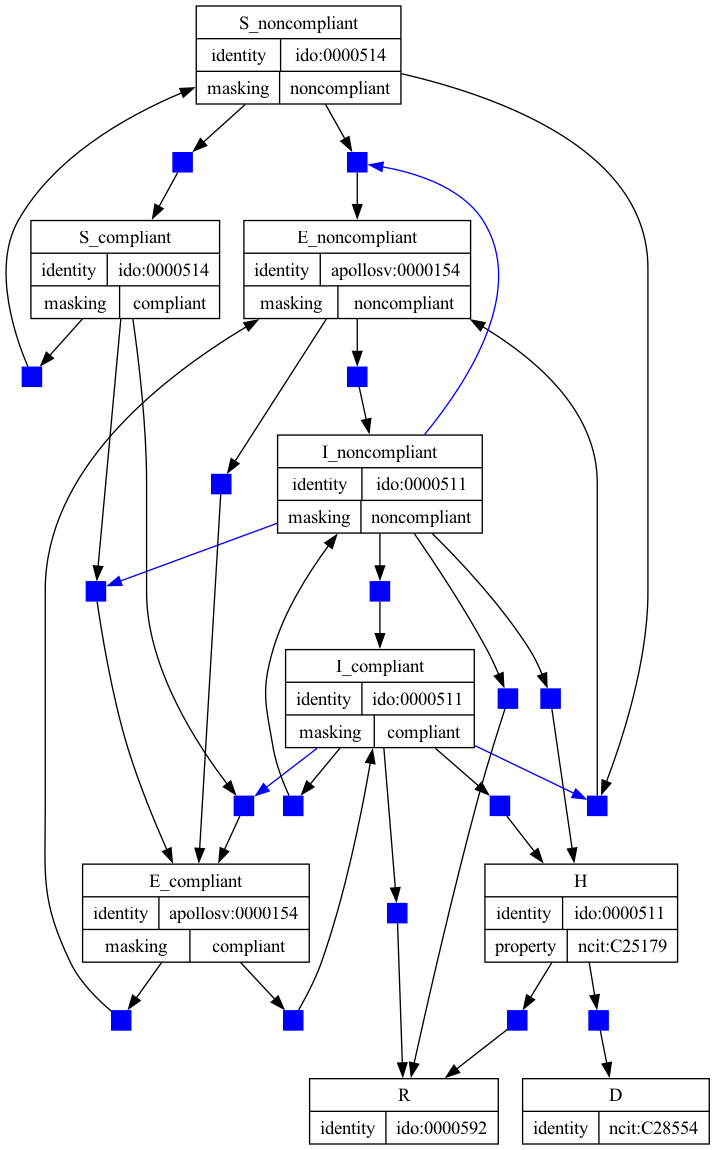

In [10]:
GraphicalModel.for_jupyter(tm_mask_3)

## Part 2/c
Social Distancing Forecasts. Instead of providing masks for all residents, the governor is interested in enforcing a social distancing policy to reduce contact between individuals. As before, begin with an SEIRHD model as described in the scenario description. For this
4
question, assume that a social distancing policy will go into place on April 15th, 2020. Starting from April 3rd, 2020, forecast the next four weeks of the pandemic (for cases, hospitalizations, and deaths)


(2) (TA2 Model Stratification Workflow) As before, begin with an SEIRHD model as described in the scenario description. Stratify it by 18 age groups (0-4, 5-9, 10-14, 15-19, 20-24, ..., 80-84, 85+). For simplification purposes, before performing the stratification, you may remove the Exposed compartment. The final result for this question will be a stratified SIRHD model. Use the following data for population estimates / initial conditions: https://www.health.ny.gov/statistics/vital_statistics/2016/table01.htm
Update parameters and probabilities introduced from stratification, with reasonable assumptions, from (for example) the following resources: https://www.cdc.gov/coronavirus/2019-ncov/hcp/planning-scenarios.html
    5
 https://docs.buckymodel.com/en/latest/input_output.html https://doi.org/10.3389/fpubh.2020.598547 https://doi.org/10.3201/eid2611.201074

In [11]:
ages = [f'{i*5}_{(i+1)*5-1}' for i in range(17)]
ages.append('85')

In [12]:
t1 = ControlledConversion(subject=c['S'],
                          outcome=c['I'],
                          controller=c['I'],
                          rate_law=S*I*beta / N)
t2 = NaturalConversion(subject=c['I'],
                       outcome=c['R'],
                       rate_law=r_I_to_R*p_I_to_R*I)
t3 = NaturalConversion(subject=c['I'],
                       outcome=c['H'],
                       rate_law=r_I_to_H*p_I_to_H*I)
t4 = NaturalConversion(subject=c['H'],
                       outcome=c['R'],
                       rate_law=r_H_to_R*p_H_to_R*H)
t5 = NaturalConversion(subject=c['H'],
                       outcome=c['D'],
                       rate_law=r_H_to_D*p_H_to_D*H)


params_sirhd = _d(parameters)
params_sirhd.pop('r_E_to_I')
initials_sirhd = _d(initials)
initials_sirhd.pop('E')

tm_sirhd = TemplateModel(
    templates=[t1, t2, t3, t4, t5],
    parameters=parameters,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables,
    annotations=Annotations(name='Evaluation Scenario 1 SIRHD model')
)

sanity_check_tm(tm_sirhd)
template_model_to_petrinet_json_file(tm_sirhd, 'eval_202307_scenario1_2_sirhd_petri.json')


tm_age = stratify(tm_sirhd,
                  key='age',
                  strata=ages,
                  structure=[],
                  directed=False,
                  params_to_stratify={'beta'},
                  cartesian_control=True)
tm_age.annotations.name = 'Evaluation Scenario 1 SIRHD model age stratified'


sanity_check_tm(tm_age)
template_model_to_petrinet_json_file(tm_age, 'eval_202307_scenario1_2_sirhd_age_petri.json')

GraphicalModel.for_jupyter(tm_age)

In [13]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.DataFrame([[p.name, p.value] for p in tm.parameters.values()], columns=['Name', 'Value'])

,Name,Value
0,beta,0.40
1,r_E_to_I,0.20
2,r_I_to_H,0.10
3,p_I_to_H,0.20
4,r_I_to_R,0.07
5,p_I_to_R,0.80
6,r_H_to_R,0.10
7,p_H_to_R,0.88
8,r_H_to_D,0.10
9,p_H_to_D,0.12
